In [1]:
import os
import joblib
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, timezone
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [3]:
pip install hopsworks[python]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.6/258.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 640.5/640.5 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import hopsworks

project = hopsworks.login(
    project="MyAQI_Predictor",  # Replace with your Hopsworks project name
    api_key_value="ir5PKrvMxVGQtr4I.OJAzB9b685t2LvfMHguGosCsipkeOyV0XSRsiz5ia81FyxNkSlgHW5eGY6b3W99O",  # Fetch API key from Streamlit secrets
)
fs = project.get_feature_store()

Copy your Api Key (first register/login): https://c.app.hopsworks.ai/account/api/generated

Paste it here: ··········

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1210516


In [5]:
# Define the feature group
air_quality_fg = fs.get_or_create_feature_group(
    name='aqi_featuregroup',
    description='Air Quality characteristics of each day',
    version=2,
    primary_key=["index"],
    online_enabled=True
)

In [6]:
# Feature View Creation and Retrieval
query = air_quality_fg.select([
    'aqi_rolling_mean_3',
    'aqi_lag_1',
    'aqi_rolling_mean_7',
    'aqi_lag_2',
    'aqi_lag_3',
    'components.so2',
    'components.pm2_5',
    'components.nh3',
    'components.pm10',
    'components.co',
    'temperature_humidity_interaction',
    'relative_humidity_2m',
    'temperature_2m',
    'main_aqi'  # Ensure the target variable is included
])

In [7]:
version = 2 # Update this versioning as needed

try:
    feature_view = fs.create_feature_view(
        name='air_quality_fv',
        version=version,
        labels=['main_aqi'],  # Target variable
        query=query
    )
    print(f"Feature view created: Version {version}")
except Exception as e:
    feature_view = fs.get_feature_view(name='air_quality_fv', version=version)
    print(f"Using existing feature view: Version {version}")

Using existing feature view: Version 2


In [8]:
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = feature_view.train_test_split(
    description='aqi prediction dataset',
    test_size=TEST_SIZE,
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.60s) 


In [9]:
y_train.value_counts(normalize=True)

,proportion
main_aqi,
0.50,0.354639
1.00,0.275862
0.75,0.213389
0.25,0.143991
0.00,0.012119


In [10]:
y_train = y_train.values.ravel() # Convert y_train to 1D
y_test = y_test.values.ravel() # Convert y_train to 1D

In [11]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
score = model.score(X_test, y_test)
print(f"Model R^2 score: {score}")

# Evaluate the model
y_pred = model.predict(X_test)
from sklearn.metrics import r2_score, mean_squared_error
print("R2 Score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

Model R^2 score: 1.0
R2 Score: 1.0
Mean Squared Error: 0.0


In [12]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"Training R²: {train_score}, Testing R²: {test_score}")

Training R²: 1.0, Testing R²: 1.0


In [13]:
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
score = model.score(X_test, y_test)
print(f"Model R^2 score: {score}")

# Evaluate the model
y_pred = model.predict(X_test)
from sklearn.metrics import r2_score, mean_squared_error
print("R2 Score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

Model R^2 score: 0.9999999961587381
R2 Score: 0.9999999961587381
Mean Squared Error: 2.7644016187010055e-10


In [14]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"Training R²: {train_score}, Testing R²: {test_score}")

Training R²: 0.9999999961922116, Testing R²: 0.9999999961587381


In [15]:
import pandas as pd
import numpy as np

rmse_results = {
    'RandomForestRegressor': 0.0,  # RMSE for RandomForestRegressor
    'XGBRegressor': 1.66282e-5,   # RMSE for XGBRegressor
}


def select_best_model(rmse_results):
    """Selects the model with the lowest RMSE.

    Args:
        rmse_results (dict): A dictionary where keys are model names and values are RMSE scores.

    Returns:
        str: The name of the best model.
    """

    # Find the model with the lowest RMSE
    best_model = min(rmse_results, key=rmse_results.get)
    return best_model


best_model_name = select_best_model(rmse_results)
print(f"The best model is: {best_model_name} with RMSE: {rmse_results[best_model_name]:.10f}")


The best model is: RandomForestRegressor with RMSE: 0.0000000000


In [16]:
# Connect to Hopsworks
project = hopsworks.login()
mr = project.get_model_registry()

Connection closed.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1210516


In [17]:
# Save the best model
model_dir = "best_model"
os.makedirs(model_dir, exist_ok=True)

joblib.dump(model, f"{model_dir}/model.pkl")

['best_model/model.pkl']

In [18]:
import hopsworks

# Assuming 'best_model' and 'model_dir' are defined as in your previous code
project = hopsworks.login()
mr = project.get_model_registry()

# Specify the model directory
model_dir = "best_model"

# Create a ModelRegistry object
model = mr.python.create_model(
    name="air_quality_prediction_model",
    metrics={"accuracy": 0.9}, # Replace with your actual metric
    description="Model for predicting air quality",
    input_example=X_train.iloc[[0]], # Provide an input example
    model_schema=None # Optionally add model schema
)

# Upload the model to Hopsworks
model.save(model_dir)

Connection closed.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1210516


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/81075 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/262 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1210516/models/air_quality_prediction_model/1


Model(name: 'air_quality_prediction_model', version: 1)

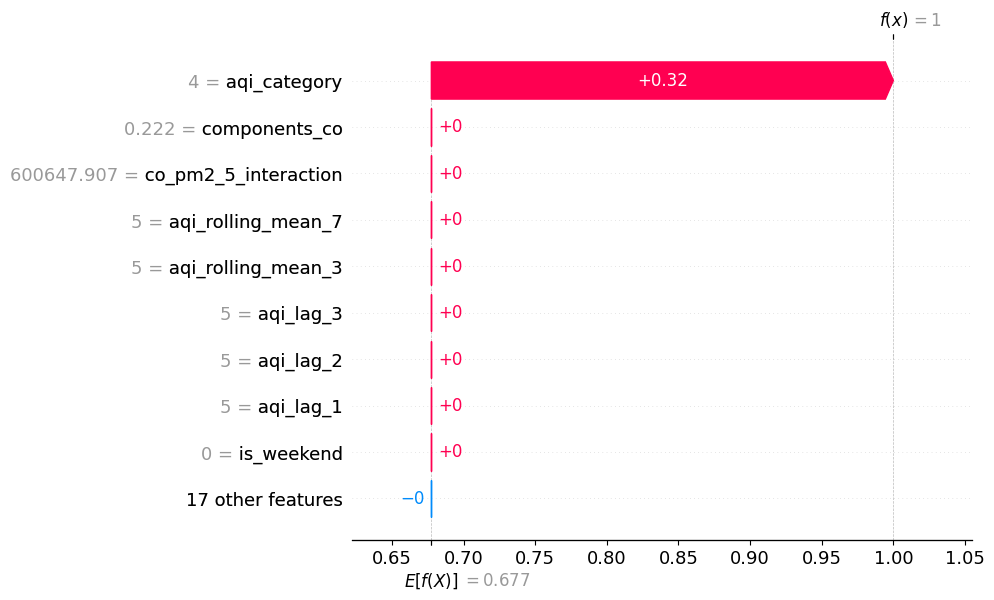

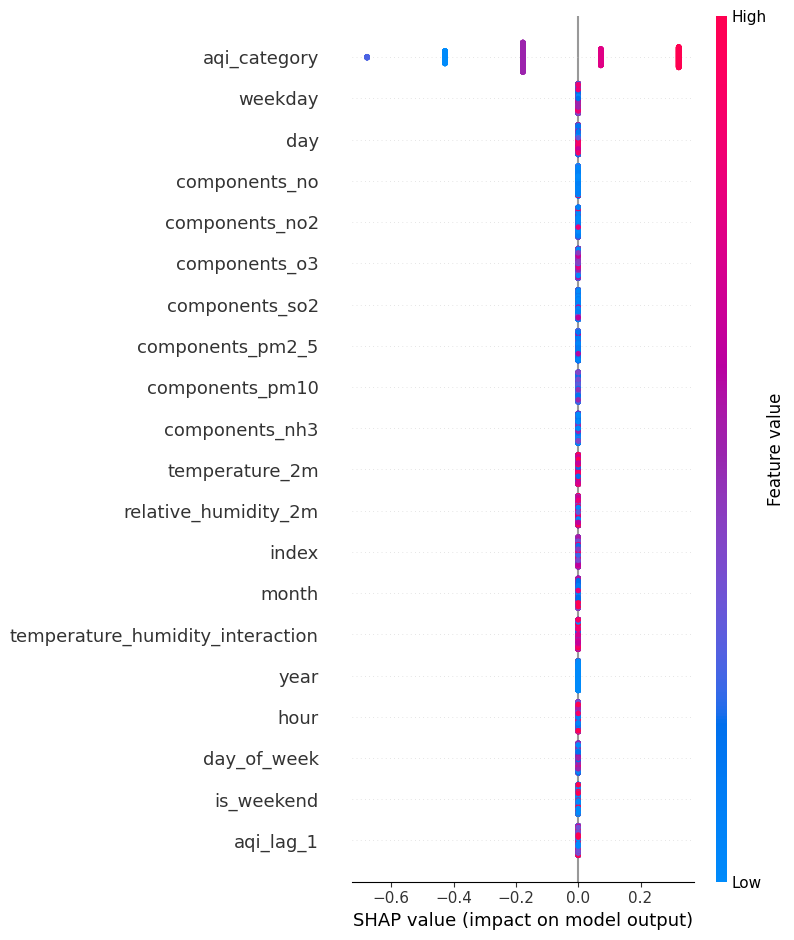

,col_name,shap_importance
17,aqi_category,0.238776
0,components_co,0.000000
1,components_no,0.000000
24,temperature_humidity_interaction,0.000000
23,co_pm2_5_interaction,0.000000
22,aqi_rolling_mean_7,0.000000
21,aqi_rolling_mean_3,0.000000
20,aqi_lag_3,0.000000
19,aqi_lag_2,0.000000
18,aqi_lag_1,0.000000


In [23]:
!pip install shap

import shap
import joblib
import numpy as np

# Load the trained model
model = joblib.load("best_model/model.pkl")

# Explain the model's predictions using SHAP values
explainer = shap.Explainer(model, X_train)  # Use X_train for the explainer
shap_values = explainer(X_test)

# Visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

# Get feature importance
shap_importance = np.abs(shap_values.values).mean(0)
feature_importance_df = pd.DataFrame(
    list(zip(X_test.columns, shap_importance)), columns=["col_name", "shap_importance"]
).sort_values("shap_importance", ascending=False)

feature_importance_df